<a href="https://colab.research.google.com/github/matthewbegun/MXN500/blob/main/MXN500_2024_LEC_11_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MXN500 Lecture 11 - And now for some more linear models!


In [1]:
#@title Imports
if (!require(pacman)) install.packages("pacman")
pacman::p_load(tidyverse, broom, GGally)

Loading required package: pacman



In [2]:
#@title Options
options(repr.plot.width=15, repr.plot.height=5, repr.plot.pointsize=24)

## Slide 11 - Correlation in Action

1. What is the correlation between petal length and petal width in the `iris` data set?
1. What do you expect the $𝑅^2$ value to be if you fit a linear model using petal width as the outcome variable, based on your result in above?
1. Which physio-chemical water quality variables in the `Ecologyv2.csv` data set are related to taxon richness?


In [3]:
# What is the correlation between petal length and petal width in the iris data set?
cor(iris$Petal.Length, iris$Petal.Width)

[1] 0.9628654

In [4]:
# What do you expect the  R2  value to be if you fit a linear model using petal width as the outcome variable, based on your result in above?
cor(iris$Petal.Length, iris$Petal.Width)^2

[1] 0.9271098

In [5]:
# Can confirm this:
summary(lm(data=iris, Petal.Width ~ Petal.Length))


Call:
lm(formula = Petal.Width ~ Petal.Length, data = iris)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.56515 -0.12358 -0.01898  0.13288  0.64272 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.363076   0.039762  -9.131  4.7e-16 ***
Petal.Length  0.415755   0.009582  43.387  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2065 on 148 degrees of freedom
Multiple R-squared:  0.9271,	Adjusted R-squared:  0.9266 
F-statistic:  1882 on 1 and 148 DF,  p-value: < 2.2e-16


Rows: 16 Columns: 40
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): Location, Site, Substrate, CoverIn, CoverOver, CoverRiparian, Susc...
dbl (31): Richness, Parastacidae, Palaemonidae, Atyidae, snail, worm, flatwo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


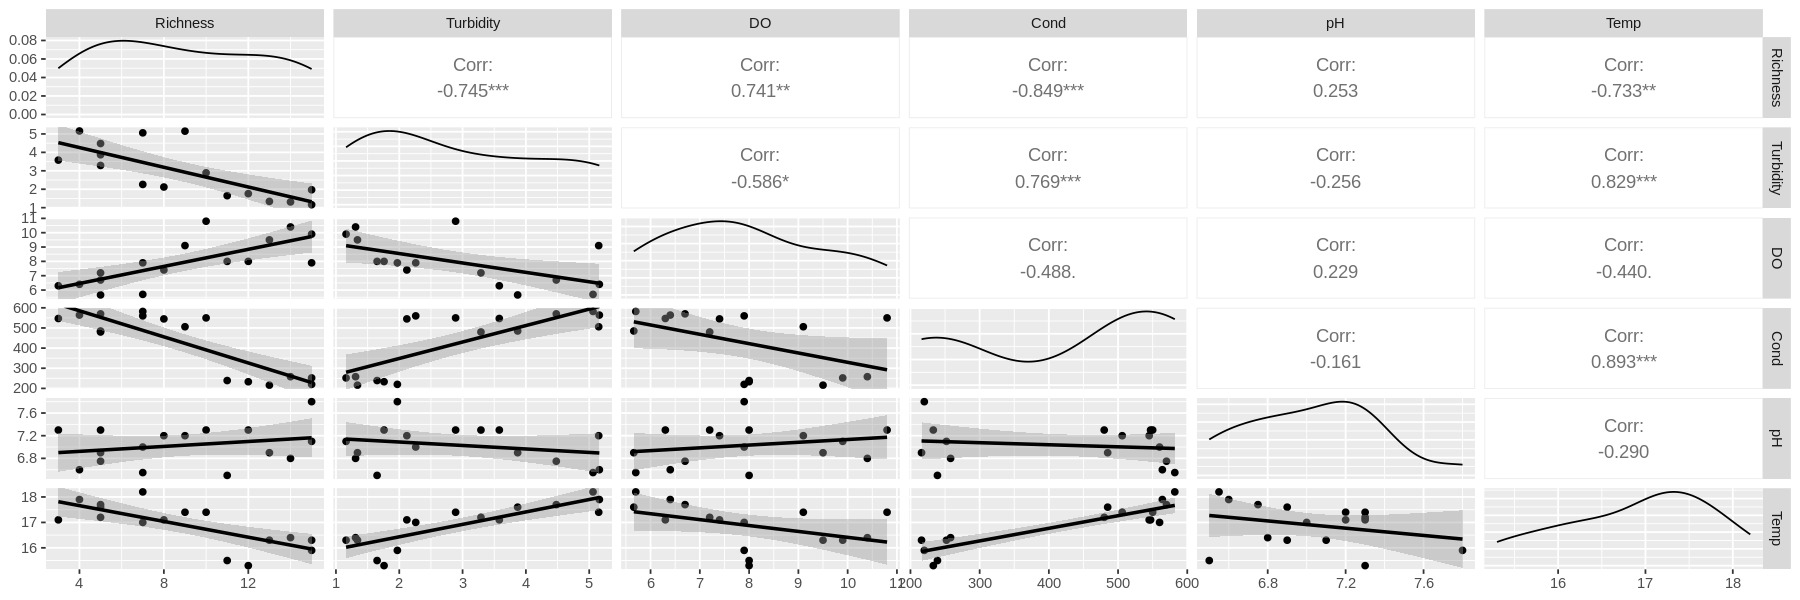

In [6]:
# Which physio-chemical water quality variables in the Ecologyv2.csv data set are related to taxon richness?
eco <- read_csv("Ecologyv2.csv")
eco_vars <- c("Richness", "Turbidity", "DO", "Cond", "pH", "Temp")
eco_pairs <- ggpairs(eco, columns = eco_vars,
                     lower=list(continuous="smooth"),
                     diag=list(continuous="densityDiag"))
eco_pairs


We can see the following things about correlation with taxon richness:
- Strong negative correlation with turbidity.
- Moderately positive correlation with dissolved oxygen.
- Strongly negative correlation with conductivity (perhaps in groups).
- Weakly positive correlation with pH (not significant).
- Moderately negative correlation with temperature.


In [7]:
# Table of correlation values:
eco_cor <- eco %>%
  select(all_of(eco_vars)) %>%
  cor() %>%
  round(., 3)
eco_cor

,Richness,Turbidity,DO,Cond,pH,Temp
Richness,1.000,-0.745,0.741,-0.849,0.253,-0.733
Turbidity,-0.745,1.000,-0.586,0.769,-0.256,0.829
DO,0.741,-0.586,1.000,-0.488,0.229,-0.440
Cond,-0.849,0.769,-0.488,1.000,-0.161,0.893
pH,0.253,-0.256,0.229,-0.161,1.000,-0.290
Temp,-0.733,0.829,-0.440,0.893,-0.290,1.000


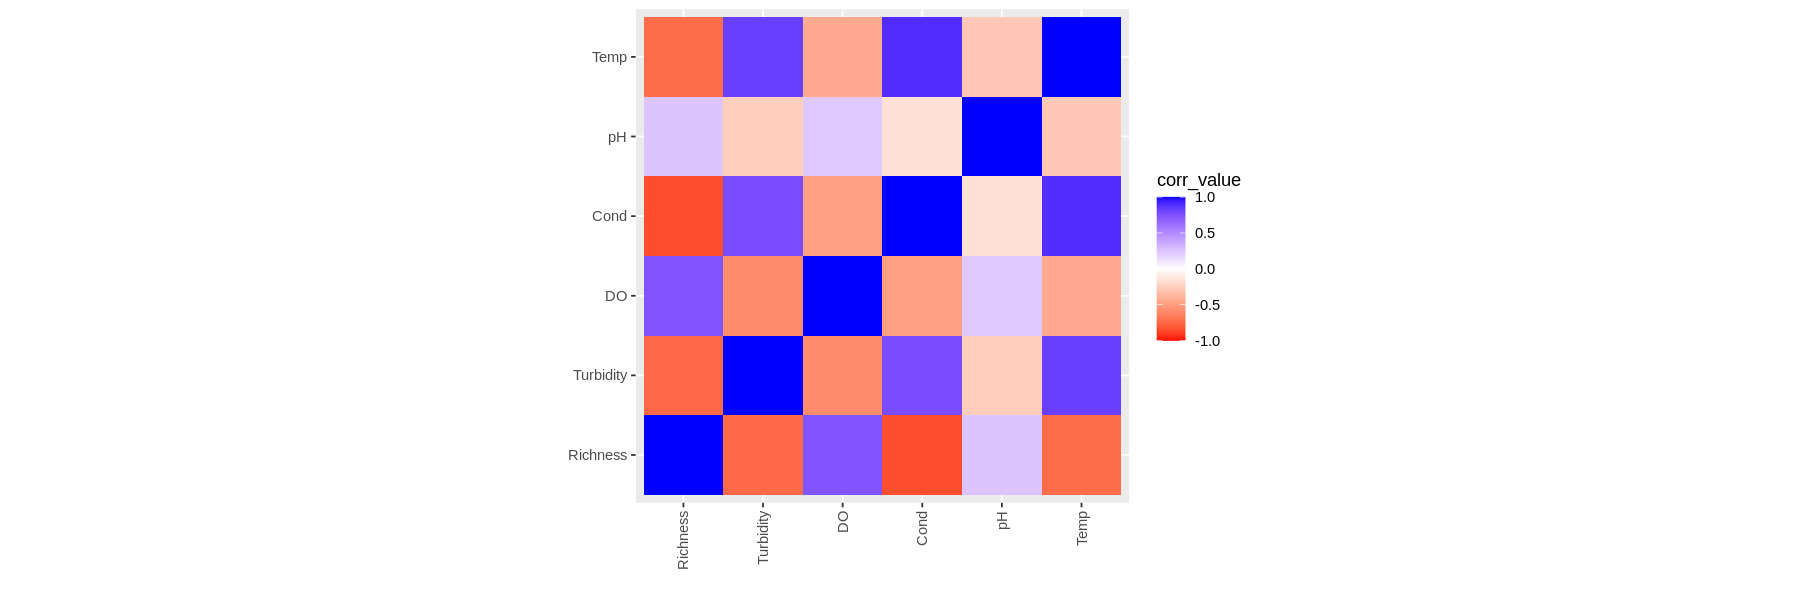

In [8]:
# Pretty picture:
cor_long <- eco_cor %>%
  as.data.frame() %>%
  mutate(X = row.names(.)) %>%
  pivot_longer(cols = -X, names_to = "Y",
               values_to = "corr_value") %>%
  mutate(X = fct_relevel(X, eco_vars),
         Y = fct_relevel(Y, eco_vars))
eco_cor_heat <- ggplot(data=cor_long,
                       aes(x=X, y=Y)) +
  geom_tile(aes(fill=corr_value)) +
  scale_fill_gradient2(low="red", mid="white",
                       high="blue", midpoint = 0, limits=c(-1,1)) +
  theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)) +
  coord_equal() + xlab("") + ylab("")
eco_cor_heat

## Slide 15 -Analysis Roadmap

The `hills` data set from the `MASS` library contains record times in 1984 for 35 Scottish hill races.
- Distance in miles (on the map), dist.
- Total height gained during the route (in feet), climb.
- Record time (minutes), time.

1. Can we predict a record time based on the distance and the height gained during the race? Answer this question by following the given analysis roadmap.


### 1. Visualise data – exploratory analysis.

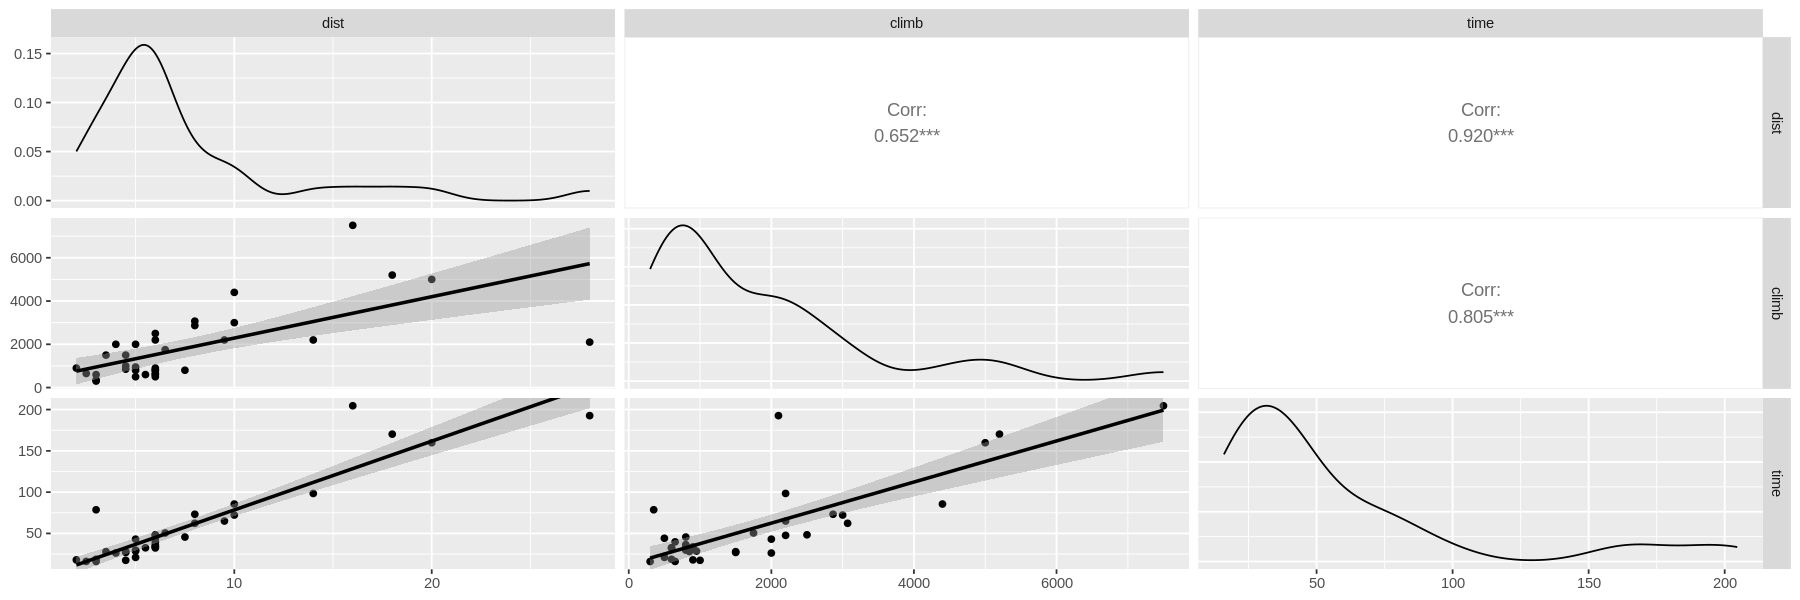

In [9]:
# load the hills data
hills <- MASS::hills

# Visually summarise the data so that the reader understands what it is.
# Visualise all variables separately.
hills_pairs <- ggpairs(hills,
                       lower=list(continuous="smooth"),
                       diag=list(continuous="densityDiag"))
hills_pairs

In [10]:
# Produce some numerical summaries.
hills %>%
  pivot_longer(c(dist, climb,  time), names_to = "variable", values_to = "value")  %>%
  group_by(variable) %>%
  summarise(Mean = mean(value),
            SD = sd(value),
            Min = min(value),
            Max = max(value))

variable,Mean,SD,Min,Max
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
climb,1815.314286,1619.150536,300.00,7500.000
dist,7.528571,5.523936,2.00,28.000
time,57.875714,50.040716,15.95,204.617


### 2. Fit linear model.


- Estimate parameters.
- Calculate confidence intervals to summarise parameter uncertainty.
- Perform 𝑡 tests to check necessity of parameters.

In [11]:
# Model specifying that time varies with dist and climb together.
hills_fit <- lm(data = hills, time ~ dist + climb)
hills_fit_tidy <- tidy(hills_fit, conf.int = TRUE)
hills_fit_tidy

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-8.99203896,4.302734388,-2.089843,4.466516e-02,-17.756422101,-0.22765581
dist,6.21795571,0.601147884,10.343471,9.859214e-12,4.993457537,7.44245388
climb,0.01104791,0.002050892,5.386882,6.445183e-06,0.006870381,0.01522544


For each parameter in our model, we want to know whether it is significantly different from zero with $\alpha=0.05$.

In this instance, we have evidence to reject the null hypothesis for each parameter.

Also have evidence to reject `intercept = 0`, but this is not as important, given that the model isn't feasible when `dist = 0` and `climb = 0`.


### 3. Assess goodness of fit.


In [12]:
# How well did our model explain the variability in the data?
# Let's look at our R-squared value.
glance(hills_fit)$r.squared



[1] 0.9190511

In [13]:
# If we had have fit our two models for dist and climb separately, we'd have:
lm(data = hills, time ~ dist) %>% glance() %>% select(r.squared)
lm(data = hills, time ~ climb) %>% glance() %>% select(r.squared)


r.squared
<dbl>
0.8456444


r.squared
<dbl>
0.6484101


 Remember: R_squared isn't just the sum of the R-squared values of these two models.

 Also, we can't treat R-squared as the square of sample correlation here, as correlation is only defined for two variables but here we have three.

 Other metrics of goodness of fit are also related to model assumptions.

### 4. Check model assumptions.


- Residuals analysis.


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


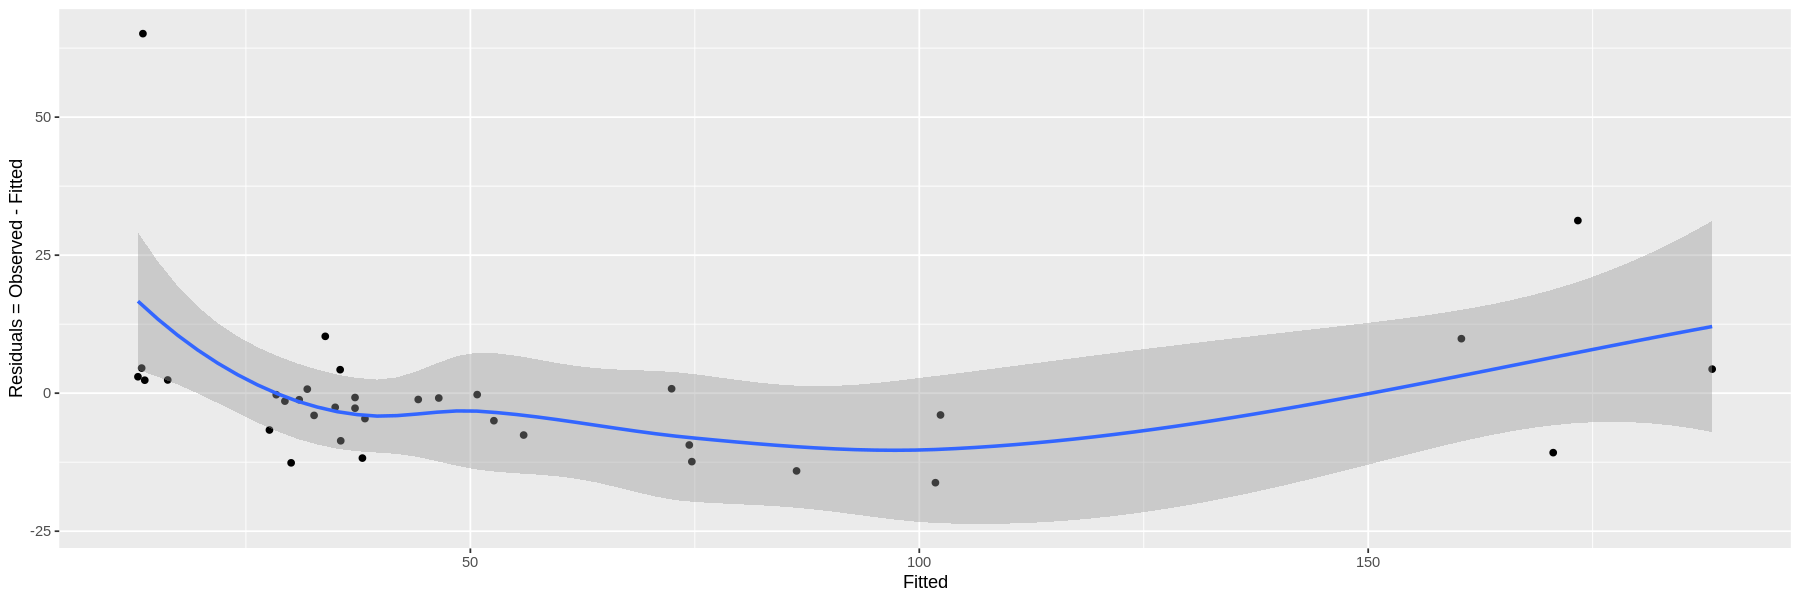

In [14]:
# use fortify to get the residuals
hills_fit_fort <- fortify(hills_fit)

# plot residuals vs fitted values
ggplot(data=hills_fit_fort, aes(x=.fitted, y=.resid)) +
  geom_point() + xlab("Fitted") +
  geom_smooth() +
  ylab("Residuals = Observed - Fitted")

Some reasons for caution:
- Appears to be an outlier (top left).
- More variability for longer times.
- Mid sections doesn't have positive results (i.e., potential curvature).

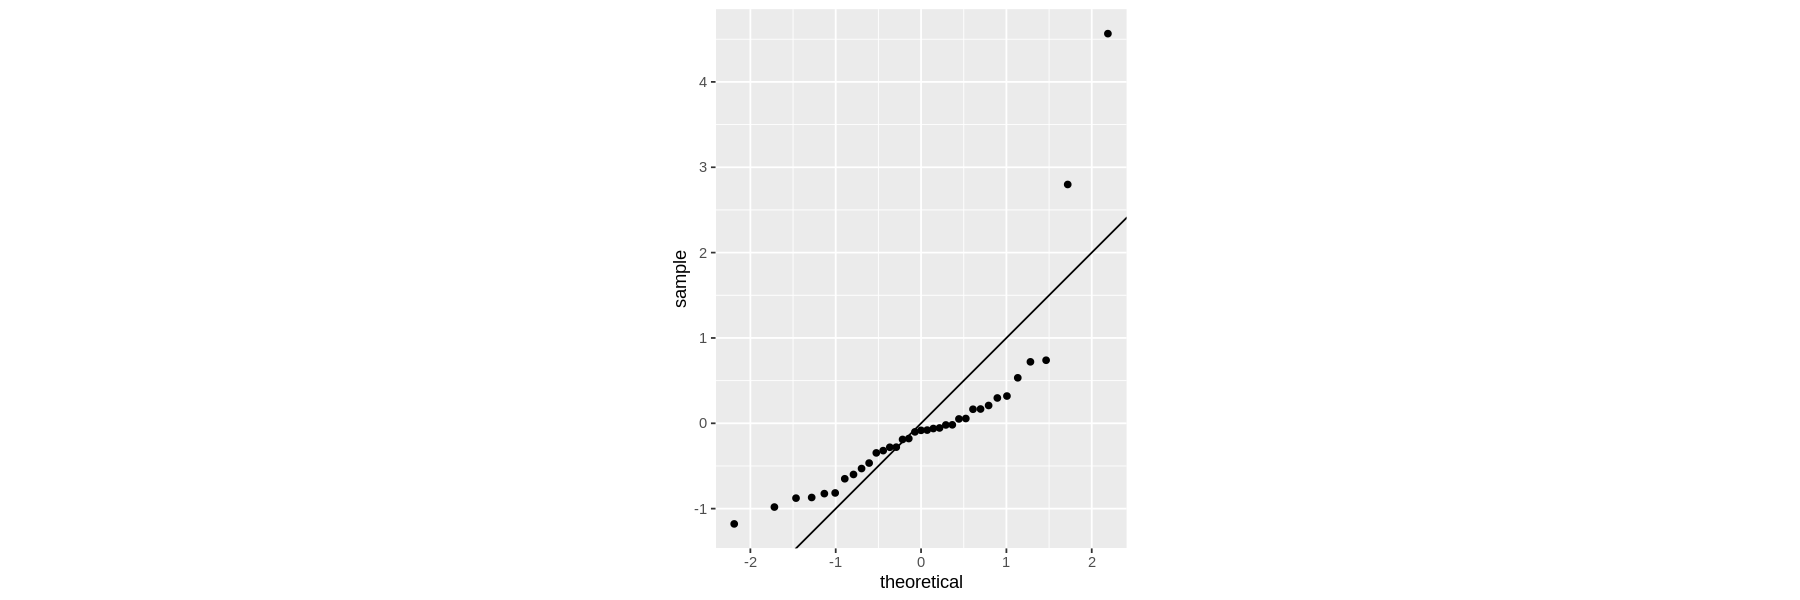

In [15]:
# QQ-plot:
ggplot(data=hills_fit_fort, aes(sample = .stdresid)) +
  stat_qq(geom="point") +
  geom_abline() +
  coord_equal()


Big red flags!
- Residuals do not follow the diagonal line.
- Strong evidence against normality assumptions.

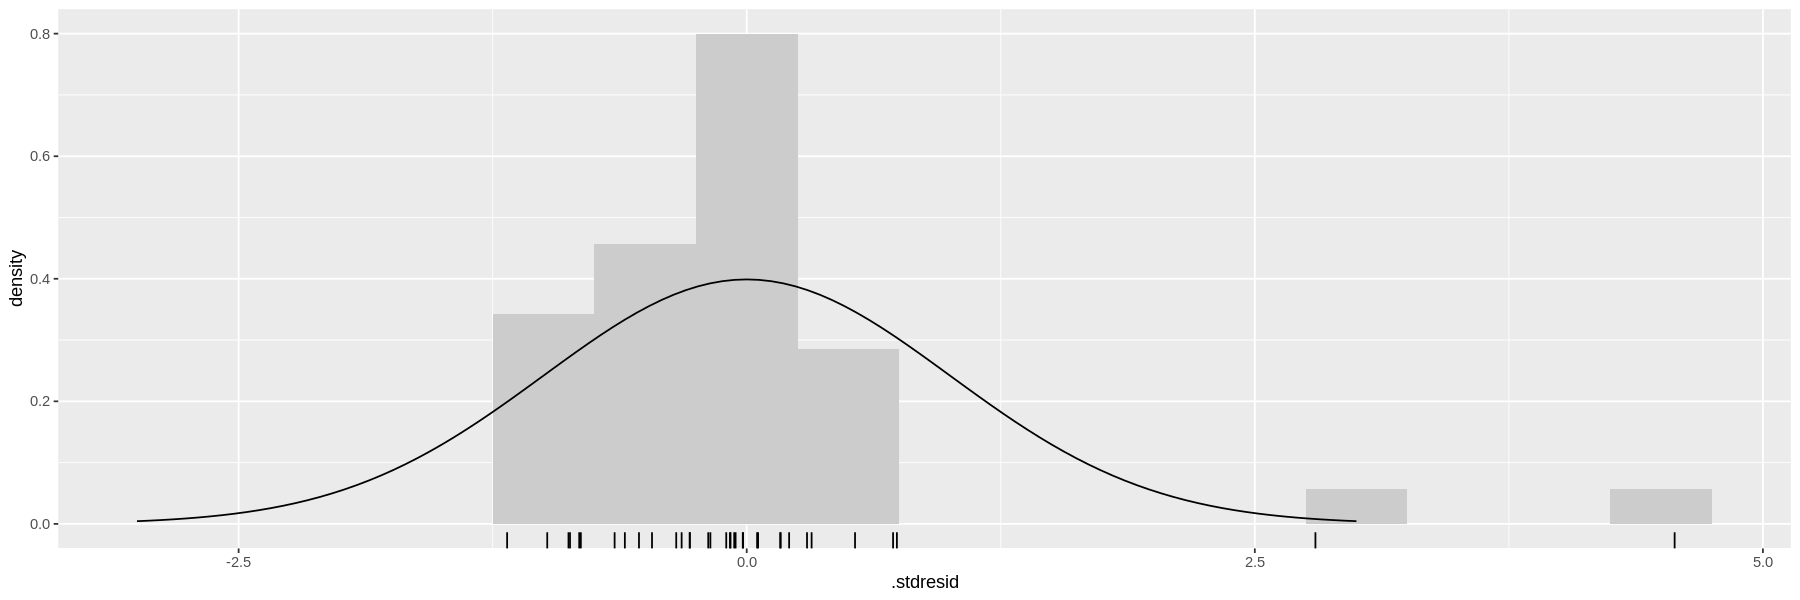

In [16]:
# Histogram:
ggplot(data=hills_fit_fort, aes(x=.stdresid)) +
  geom_histogram(fill="grey80", binwidth=0.5,
                 aes(y=after_stat(density))) +
  stat_function(fun=dnorm, xlim=c(-3,3)) +
  geom_rug()


And now for more bad news!
- Too much mass in the centre.
- A clear outlier.

What if we remove that outlier?

In [17]:
# identify the outliers
# unpack this carefully in the lecture!
(
outliers <- hills_fit_fort %>%
  arrange(desc(.stdresid)) %>%
  slice(1:2) %>%
  row.names()
)

[1] "Knock Hill"   "Bens of Jura"

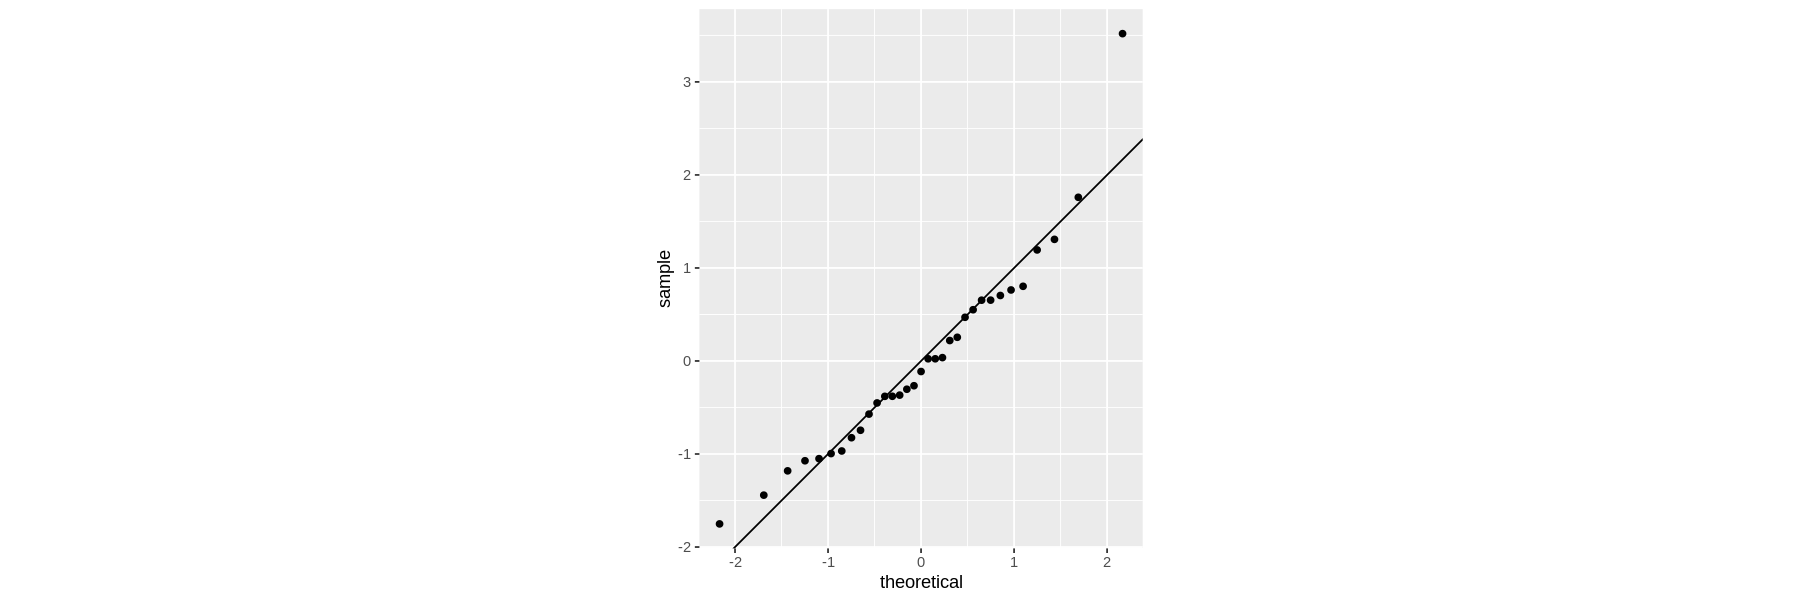

In [18]:
# create a reduced data frame excluding the outlier
hills_no_outliers <- hills %>%
  filter(!(row.names(hills) %in% outliers))

# fit a model to the new dataset
hills_fit_no_outliers <-
  lm(data = hills_no_outliers, time ~ dist + climb)

# Now check the QQ plot:
hills_fit_fort_no_outliers <- fortify(hills_fit_no_outliers)
ggplot(data=hills_fit_fort_no_outliers,
       aes(sample = .stdresid)) +
  stat_qq(geom="point") +
  geom_abline() +
  coord_equal()


Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”


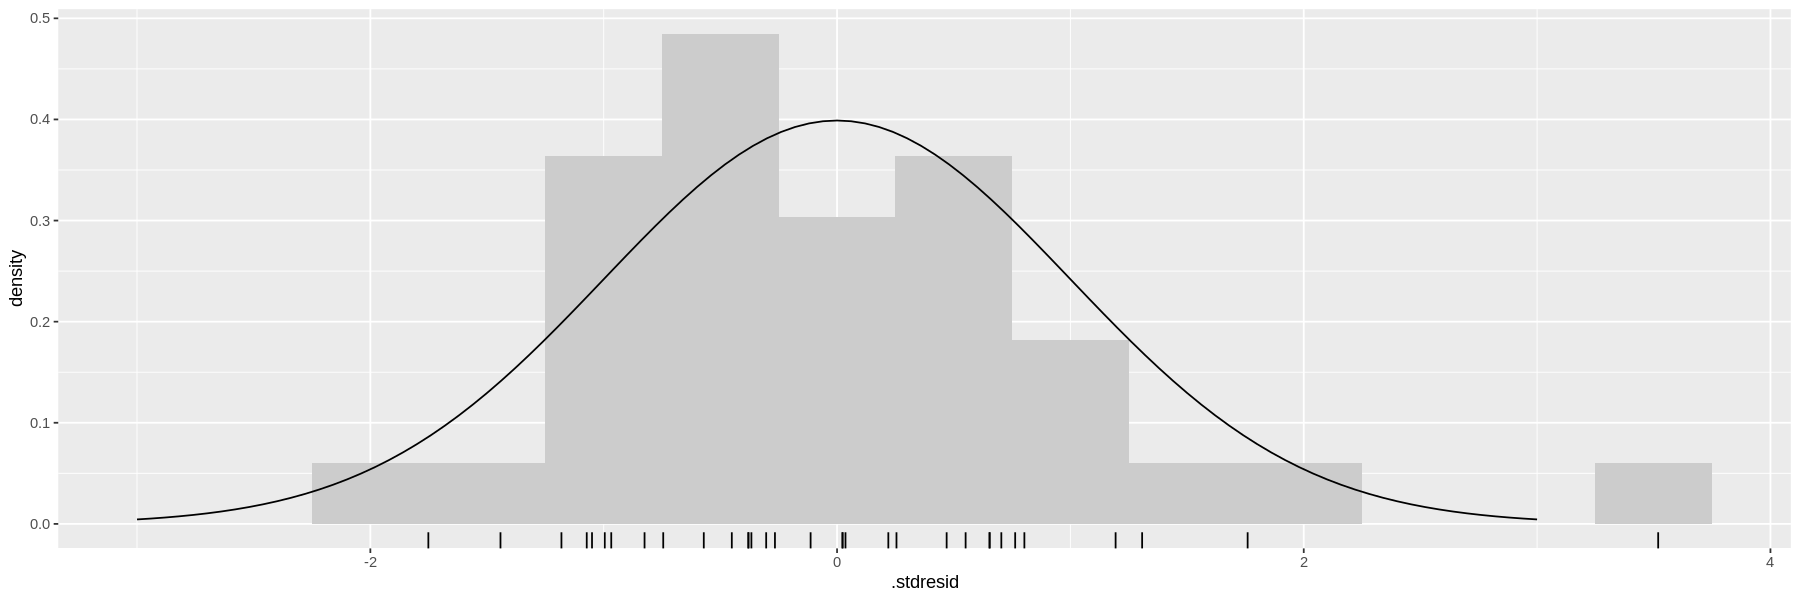

In [19]:
# The histogram?
ggplot(data=hills_fit_fort_no_outliers, aes(x=.stdresid)) +
  geom_histogram(fill="grey80", binwidth=0.5,
                 aes(y=..density..)) +
  stat_function(fun=dnorm, xlim=c(-3,3)) +
  geom_rug()

Much more like it!

### 5. Interpret model.


- Make predictions for useful scenarios.
- Summarise analysis with regards to need/question.
- Compare to similar studies.
- State conclusions you have come to, using analysis results as evidence.


#### Predictions

In [20]:
# Can't visualise predictions with a line, because there are 3 "dimensions" now.
# Use a plane instead, with different combinations of dist and climb:

# get the limits to use for the plane
range(hills_no_outliers$dist)
range(hills_no_outliers$climb)

[1]  2 28

[1]  300 5200

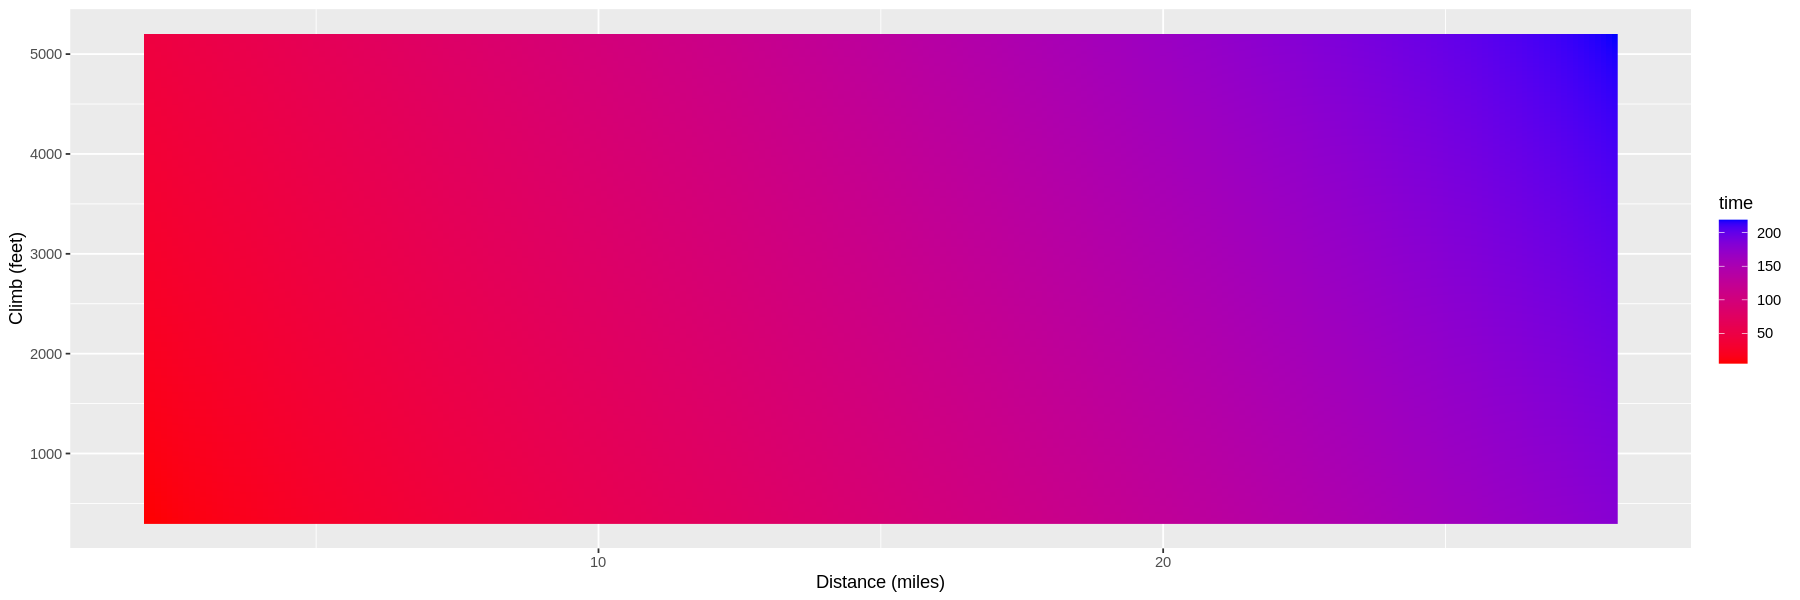

In [21]:
# create a grid to hold values over the plane
dist_new <- seq(from=2, to=28, by=0.1)
climb_new <- seq(from=300, to=5200, by=10)
hills_newdata <- expand.grid(dist=dist_new,
                             climb=climb_new)

# fill the grid with predictions
hills_newdata$time <- predict(hills_fit_no_outliers, hills_newdata)

# plot the plane
hills_pred_ggplot <- ggplot(data = hills_newdata, aes(x=dist, y=climb)) +
  geom_raster(aes(fill=time)) +
  scale_fill_gradient(low="red", high="blue") +
  xlab("Distance (miles)") +
  ylab("Climb (feet)") +
  theme(legend.position="right")
hills_pred_ggplot

- Increasing climb height increases the time taken.
- Increasing the distance run increases the time taken.
- Both an increase in climb height and distance run increases the overall time.


#### Summarise


- Can see dist and climb play an important role in predicting time.
- So, we fit a linear regression model with two explanatory variables.
- Need to be careful about meeting our assumptions.
- Justify and omit outliers with caution.


## Slide 17

The `whiteside` data set from the `MASS` library contains weekly gas consumption and average outdoor temperature before and after installing insulation.
1. Analyse gas consumption as a model insulation and temperature, considering interactions.
2. Consider the same parameters, this time fitting a model with no intercept.


`geom_smooth()` using formula = 'y ~ x'


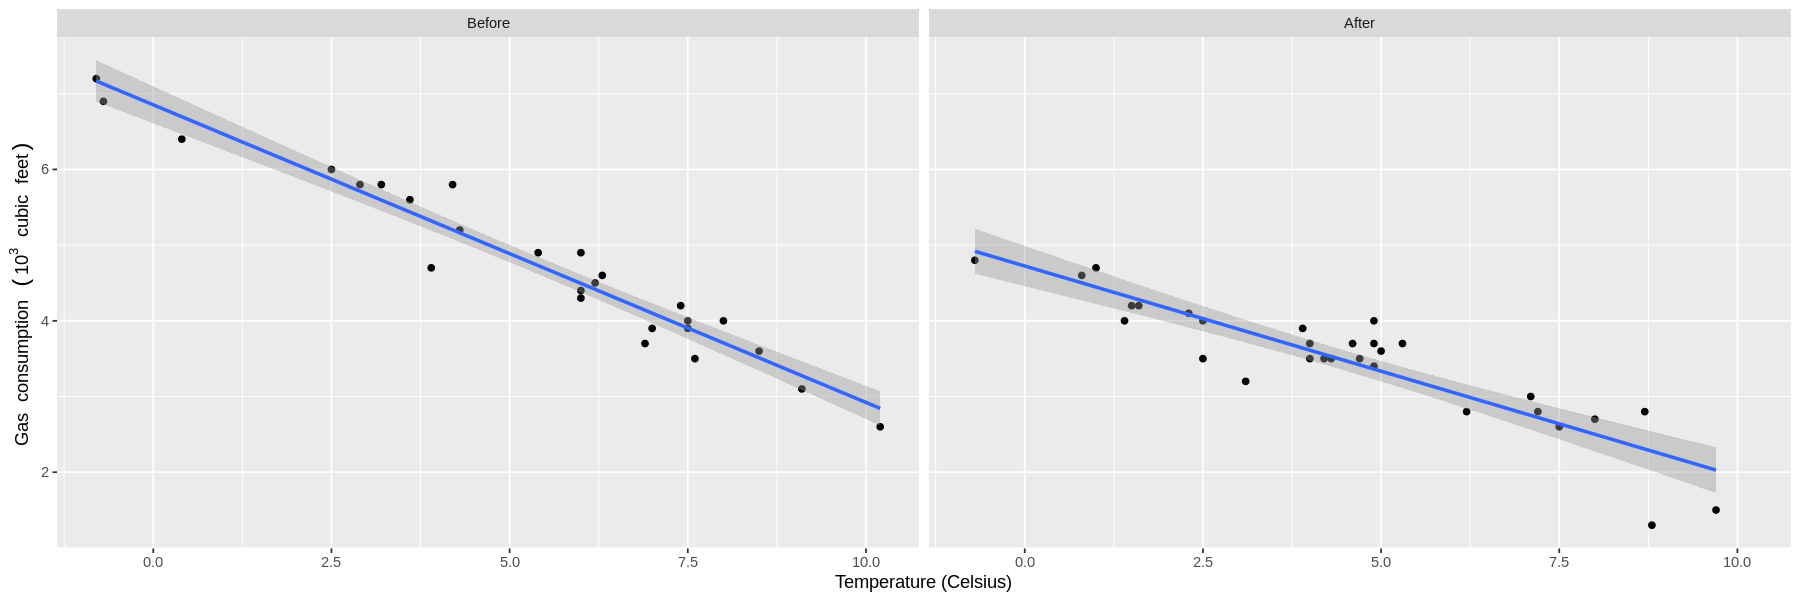

In [22]:
# grab the whiteside data set
whiteside <- MASS::whiteside

# Visualise weekly gas consumption and average outdoor temperature before and
# after installing insulation.
gg.white <- ggplot(data=whiteside, aes(x=Temp, y=Gas)) +
  geom_point() + geom_smooth(method="lm") +
  facet_wrap( ~ Insul) +
  xlab("Temperature (Celsius)") +
  ylab(expression(Gas~consumption~(10^{3}~cubic~feet)))
gg.white

- Gas consumption lower overall when insulation installed.
- Maybe the slope of the consumption-temperature line is different before and
  after insulation is installed.
- What effect does installing insulation have on gas consumption?

### Fit the first model:

In [23]:
summary(
lm.gas <- lm(data=whiteside, Gas ~ Temp * Insul)
)


Call:
lm(formula = Gas ~ Temp * Insul, data = whiteside)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.97802 -0.18011  0.03757  0.20930  0.63803 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      6.85383    0.13596  50.409  < 2e-16 ***
Temp            -0.39324    0.02249 -17.487  < 2e-16 ***
InsulAfter      -2.12998    0.18009 -11.827 2.32e-16 ***
Temp:InsulAfter  0.11530    0.03211   3.591 0.000731 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.323 on 52 degrees of freedom
Multiple R-squared:  0.9277,	Adjusted R-squared:  0.9235 
F-statistic: 222.3 on 3 and 52 DF,  p-value: < 2.2e-16


This is equivalent to:

$$
Gas_i = β_0 + β_1 × Temp_i + β_2 × Ι(Insul_i == \text{After}) +
        β_3 × Temp_i × Ι(Insul_i == \text{After}) + ε_i.
$$

Where $Ι()$ is an indicator function (see week 10).


#### Aside

When you look at the results, you will see a colon, `:`, used in place of the
typical multiplication sign for interaction terms in your model summary.

This is because `R` uses the multiplication sign (`*`) in the linear model to
represent the interaction term and the individual terms, i.e.,
`lm(y ~ x*z)` gives:

$$
y_i = β_0 + β_1 x_i + β_2 z_i + β_3 x_i z_i + ε_i
$$

Where `lm(y ~ x:z)` gives:
$$
y_i = β_0 + β_1 x_i z_i + ε_i
$$

We never use the latter in practice.


### Interpret the first model:


In [24]:
gas.coef <- tidy(lm.gas, conf.int=T) %>%
  rename(`2.5%` = conf.low,
         `97.5%` = conf.high)
gas.coef

term,estimate,std.error,statistic,p.value,2.5%,97.5%
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),6.8538277,0.13596397,50.409146,7.997414e-46,6.58099603,7.1266594
Temp,-0.3932388,0.02248703,-17.487358,1.976009e-23,-0.43836236,-0.3481153
InsulAfter,-2.1299780,0.18009172,-11.827185,2.315921e-16,-2.49135850,-1.7685976
Temp:InsulAfter,0.1153039,0.03211212,3.590665,7.306852e-04,0.05086618,0.1797416


Model output now shows contribution to gas consumption as:
- `(Intercept)`: Baseline of temperature at 0 degrees before insulation.
- `Temp`: Effect of temperature.
- `InsulAfter`: Effect of installing insulation.
- `Temp:InsulAfter`: Additional effect of temperature after insulation is
  installed.


In [25]:
glance(lm.gas)


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.9276771,0.9235047,0.3230042,222.3327,1.234853e-29,3,-14.10049,38.20098,48.32774,5.425247,52,56


- All model terms significant.
- 92.35% of variability explained.
- Baseline gas consumption (ignoring effect of temperature) lower after insulation installed.
- Effect of InsulAfter is -2.13, with 95% CI (-2.4914, -1.7686).
- Effect of Temp is -0.3932, additional effect of Temp:InsulAfter is 0.1153 which means total effect of Temp post-installation is -0.2779.
- Gas consumption not as sensitive to temperature changes because slope of line is *less* negative after installing insulation. (i.e. magnitude is smaller, closer to 0)


### Fit the second model (no intercept):

In [26]:
summary(lm.gas2 <- lm(data=whiteside, Gas ~ Insul + Temp:Insul - 1))



Call:
lm(formula = Gas ~ Insul + Temp:Insul - 1, data = whiteside)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.97802 -0.18011  0.03757  0.20930  0.63803 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
InsulBefore       6.85383    0.13596   50.41   <2e-16 ***
InsulAfter        4.72385    0.11810   40.00   <2e-16 ***
InsulBefore:Temp -0.39324    0.02249  -17.49   <2e-16 ***
InsulAfter:Temp  -0.27793    0.02292  -12.12   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.323 on 52 degrees of freedom
Multiple R-squared:  0.9946,	Adjusted R-squared:  0.9942 
F-statistic:  2391 on 4 and 52 DF,  p-value: < 2.2e-16


- Model is a little more interpretable by specifying the model differently.
- Now, we only look at the effect of temperature through its interaction with insulation.


In [27]:
gas.coef2 <- lm.gas2 %>%
  tidy(conf.int=T) %>%
  rename(`2.5%` = conf.low,
         `97.5%` = conf.high)
gas.coef2

term,estimate,std.error,statistic,p.value,2.5%,97.5%
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
InsulBefore,6.8538277,0.13596397,50.40915,7.997414e-46,6.5809960,7.1266594
InsulAfter,4.7238497,0.11809668,39.99985,9.918382e-41,4.4868714,4.9608280
InsulBefore:Temp,-0.3932388,0.02248703,-17.48736,1.976009e-23,-0.4383624,-0.3481153
InsulAfter:Temp,-0.2779350,0.02292426,-12.12405,8.936039e-17,-0.3239359,-0.2319341


No longer making comparisons against a baseline
- Baseline in previous model was `Insul = Before`, estimate still same
- `InsulAfter` is no longer the difference between before and after installation
- `InsulBefore:Temp` is the effect of temperature before installation
- `InsulAfter:Temp` is the effect of temperature after installation

These two models are functionally the same.
- just specified differently
- explain the exact same amount of variability
- Remember that R-squared will be incorrectly reported in model with no intercept.


In [28]:
glance(lm.gas)
glance(lm.gas2)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.9276771,0.9235047,0.3230042,222.3327,1.234853e-29,3,-14.10049,38.20098,48.32774,5.425247,52,56


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.9945926,0.9941766,0.3230042,2391.112,3.067634e-58,4,-14.10049,38.20098,48.32774,5.425247,52,56


Key takeaways:
- Installing insulation dropped gas consumption at 0 degrees Celsius.
- Installing insulation made gas consumption less sensitive to changes in temperature.


## Slide 19 - Basic Principles – Model Selection

Consider the `whiteside` gas data set again. Assume that installing insulation only changes the intercept, i.e., the temperature-consumption relationship still has the same slope. This becomes a model with parallel lines, i.e., no interaction between variables.

$$
Gas_i = β_0 + β_1 Temp_i + β_2 Ι(Insul_i = \text{After}) + ε_i
$$

Does the previous model (with the interaction term) account for more variability in gas consumption?


In [29]:
# Our existing model:
lm.gas <- lm(data = whiteside, Gas ~ Temp * Insul)


In [30]:
# Our parallel model:
lm.gas.parallel <- lm(data = whiteside, Gas ~ Temp + Insul)

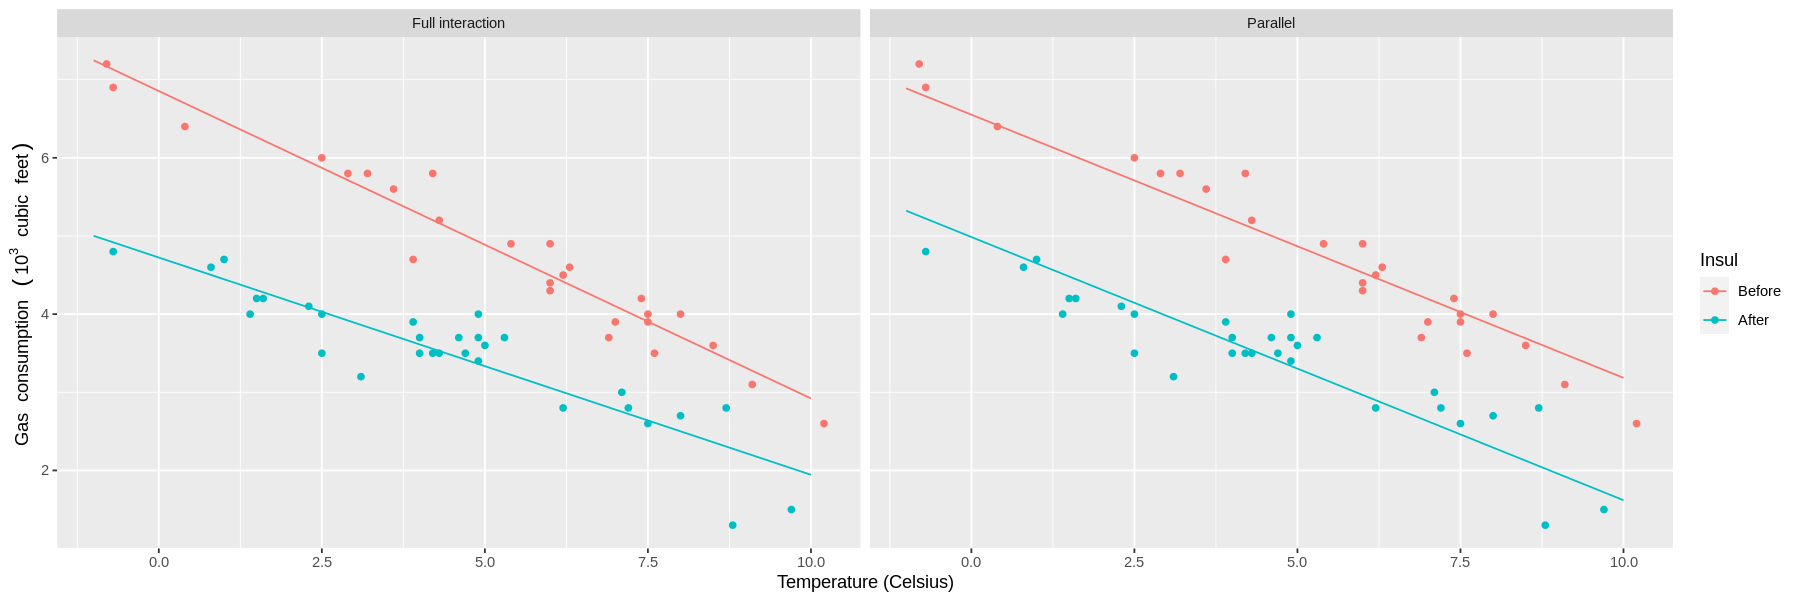

In [31]:
# Visualisation:
# grid
newdata.gas <- expand.grid(Temp = seq(-1,10,by=1),
                           Insul = c("Before", "After"))
# full model
pred.gas <- predict(lm.gas, newdata.gas) %>%
  data.frame(fit = .) %>%
  mutate(Model = "Full interaction") %>%
  bind_cols(newdata.gas)
# reduced model
pred.gas.parallel <- predict(lm.gas.parallel, newdata.gas) %>%
  data.frame(fit = .) %>%
  mutate(Model = "Parallel") %>%
  bind_cols(newdata.gas)
# plot
bind_rows(pred.gas, pred.gas.parallel) %>%
  ggplot(data=., aes(x=Temp, y=fit)) +
  geom_line(aes(group=Insul, color=Insul)) +
  facet_wrap( ~ Model, nrow=1) +
  geom_point(data=whiteside, aes(color=Insul, y=Gas)) +
  xlab("Temperature (Celsius)") +
  ylab(expression(Gas~consumption~(10^{3}~cubic~feet))) +
  theme(legend.position="right")

In [32]:
# Comparison of R-squared values:
glance(lm.gas)
glance(lm.gas.parallel)


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.9276771,0.9235047,0.3230042,222.3327,1.234853e-29,3,-14.10049,38.20098,48.32774,5.425247,52,56


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.9097454,0.9063396,0.3574116,267.1139,2.088981e-28,2,-20.30232,48.60465,56.70605,6.770382,53,56


In [33]:
# Both have Adj R-squared above 0.9
# Small increase when adding the interaction.


In [34]:
# Running ANOVA for model comparison:
anova(lm.gas.parallel, lm.gas)


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,53,6.770382,NA,NA,NA,NA
2,52,5.425247,1,1.345135,12.89287,0.0007306852


Model 1 nested inside Model 2.
- $p < 0.05$ so reject $H_0$.
- Rejecting $H_0$ implies that interaction model accounts for more variability.
- Interaction model is better based on this analysis.